This example tests compares two models with initial conditions that are different but have the same summary statistics. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np

from stochastic_models import AntimonyModel
from stochastic_tests import Test
import stochastic_repro as sr

sr.start_pool()

t_fin = 1.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000, 50000], 
                   )

mean = 0.0
stdev = 0.25

model_string = f"""
-> x ; 2 * pi * k * cos(2 * pi * k * time);
-> y ; - 2 * pi * k * sin(2 * pi * k * time);
k = 1.0

x = 0.0
y = 0.0
"""
def model(*args, **kwargs):
    return AntimonyModel(model_string, ['x', 'y'], *args, **kwargs)

test_control = Test(model=model({'x': ('norm', (mean, stdev))}), stochastic=False, **test_kwargs)
test_control.trials = [t * 2 for t in test_control.trials]

test1 = Test(model=model({'x': ('norm', (mean, stdev))}), stochastic=False, **test_kwargs)
test2 = Test(model=model({'x': ('norm', (mean, stdev))}), stochastic=False, **test_kwargs)
test3 = Test(model=model({'x': ('laplace', (mean, stdev / np.sqrt(2)))}), stochastic=False, **test_kwargs)
test4 = Test(model=model({'x': ('uniform', (mean - stdev * np.sqrt(3), stdev * np.sqrt(12)))}), stochastic=False, **test_kwargs)
test5 = Test(model=model({'x': ('logistic', (mean, np.sqrt(3) * stdev / np.pi))}), stochastic=False, **test_kwargs)
tests = [test1, test2, test3, test4, test5]
labels = ['Normal', 'Normal', 'Laplace', 'Uniform', 'Logistic']

In [2]:
for test in tests:
    test.execute_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

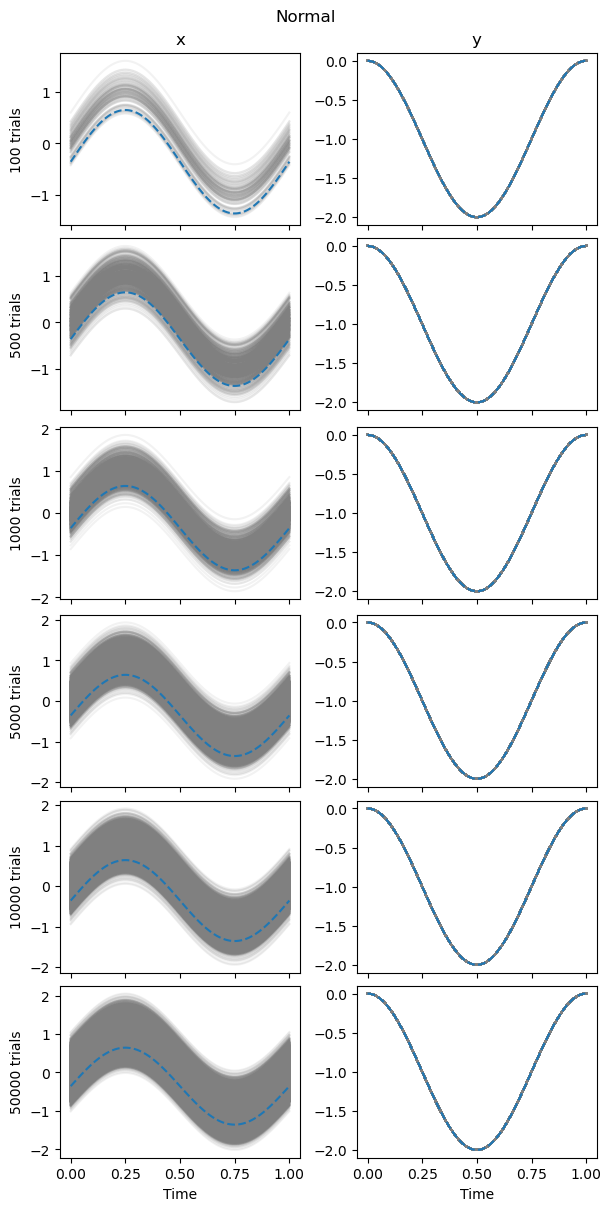

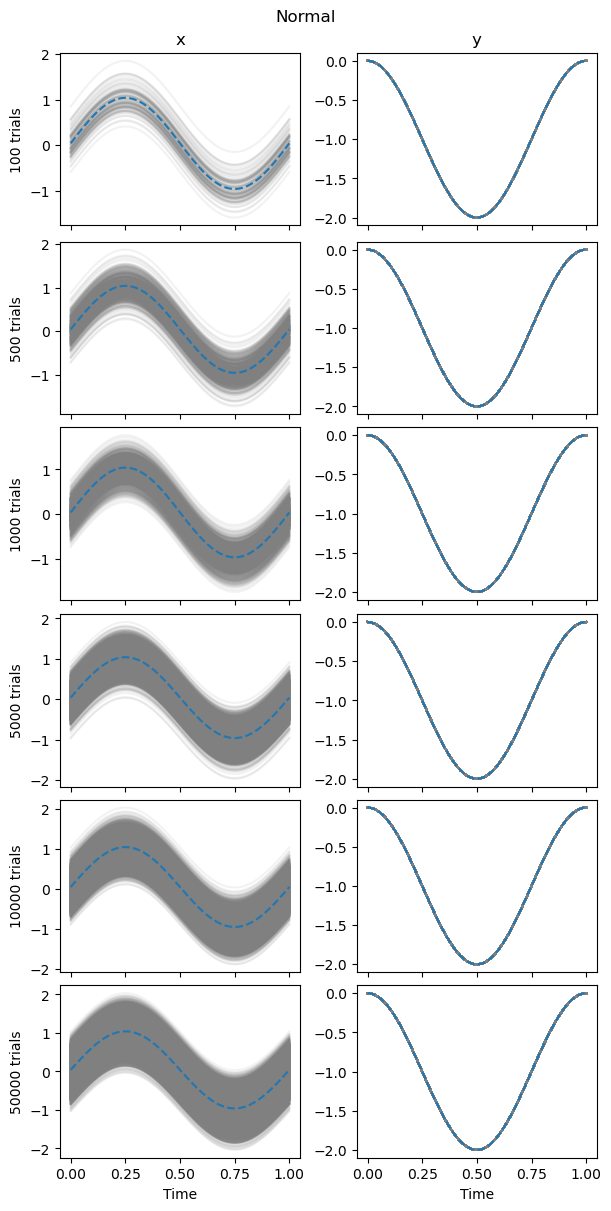

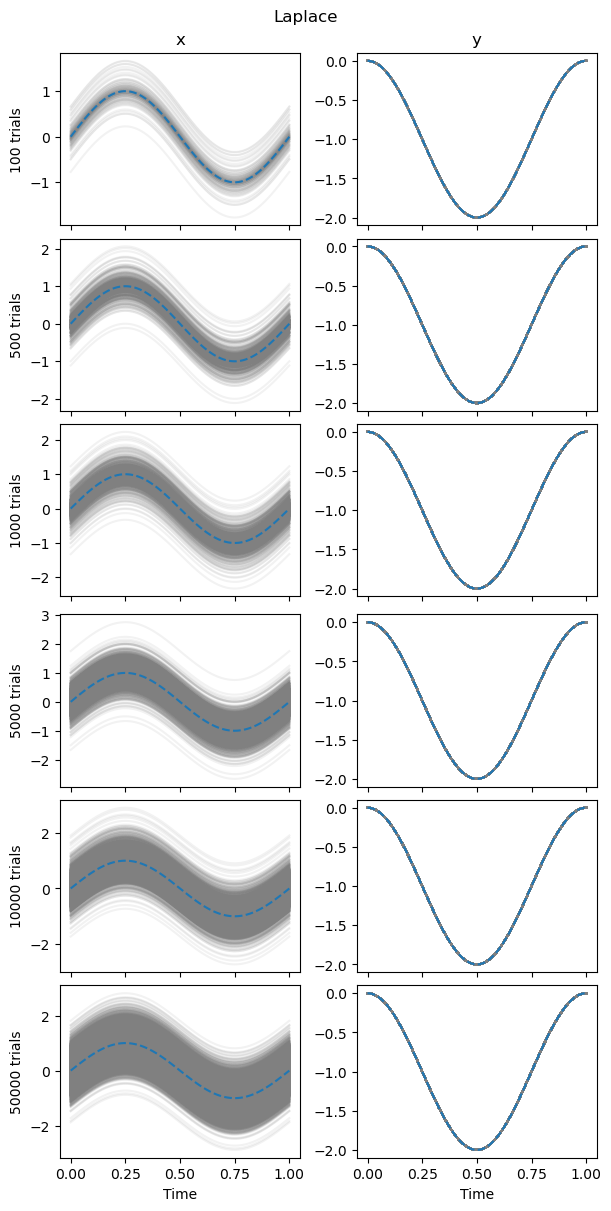

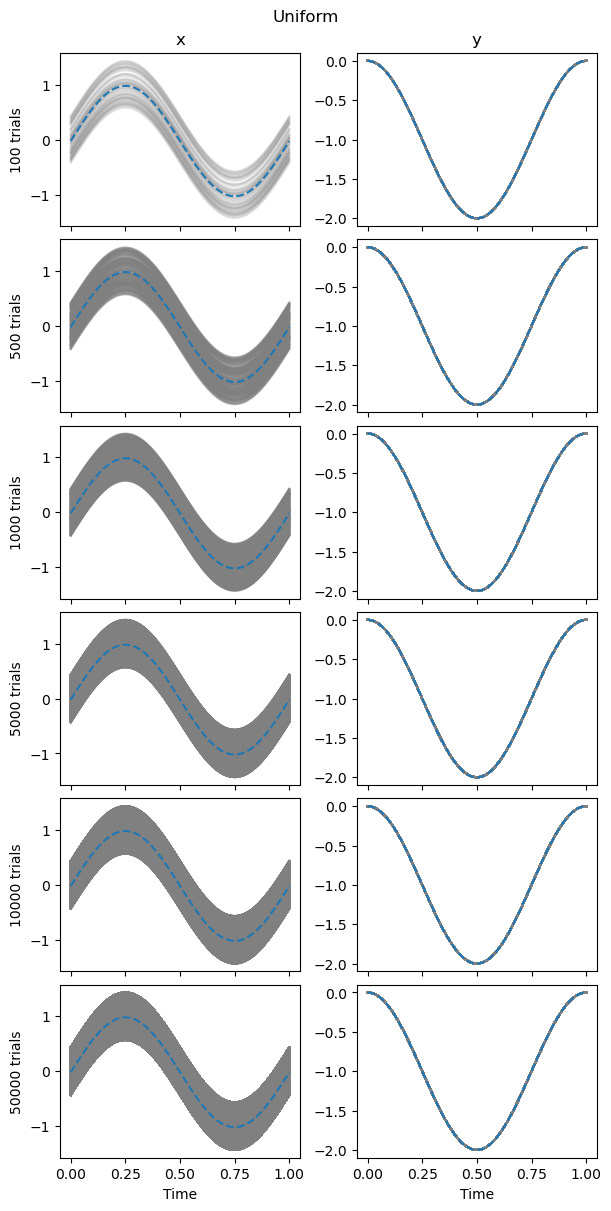

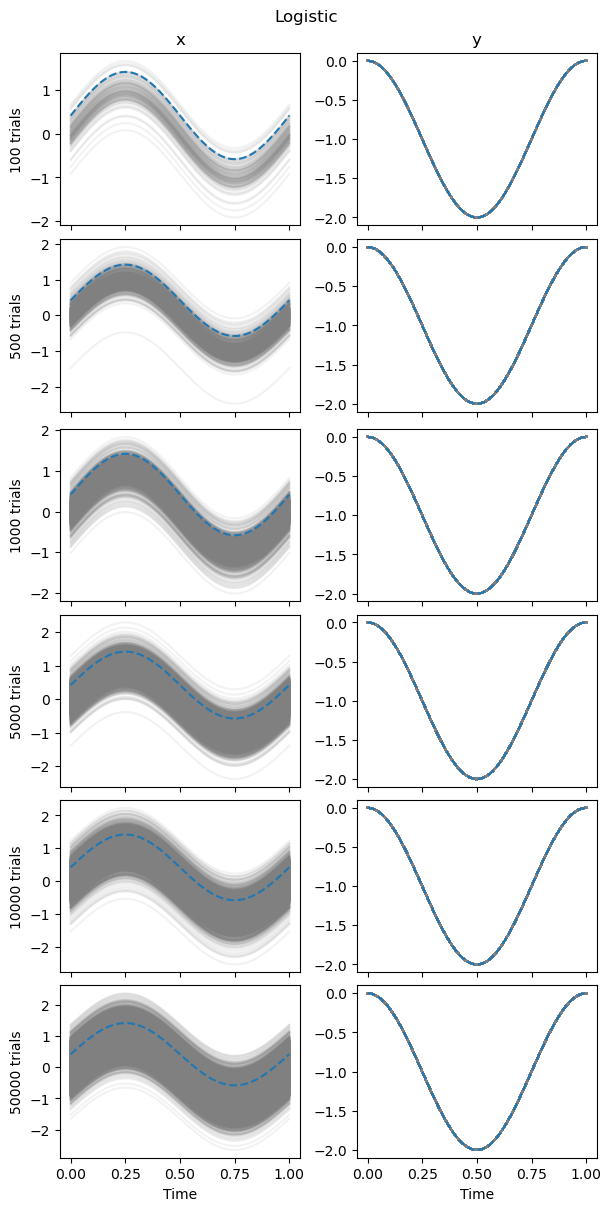

In [4]:
for i, test in enumerate(tests):
    fig = test.plot_results_stochastic()[0]
    fig.suptitle(labels[i])

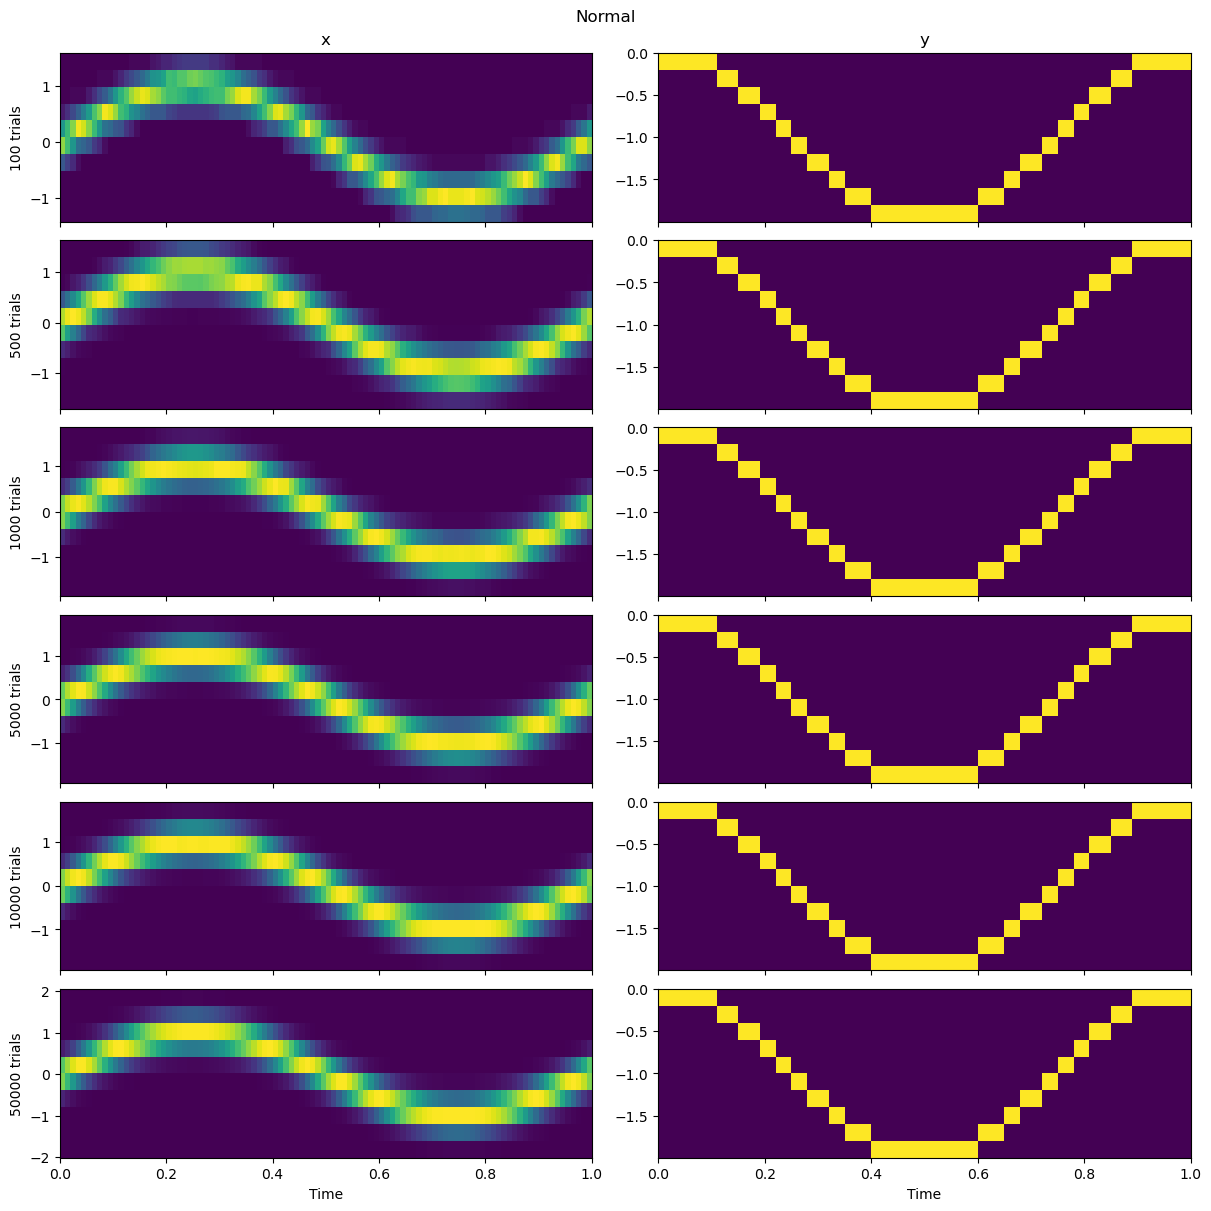

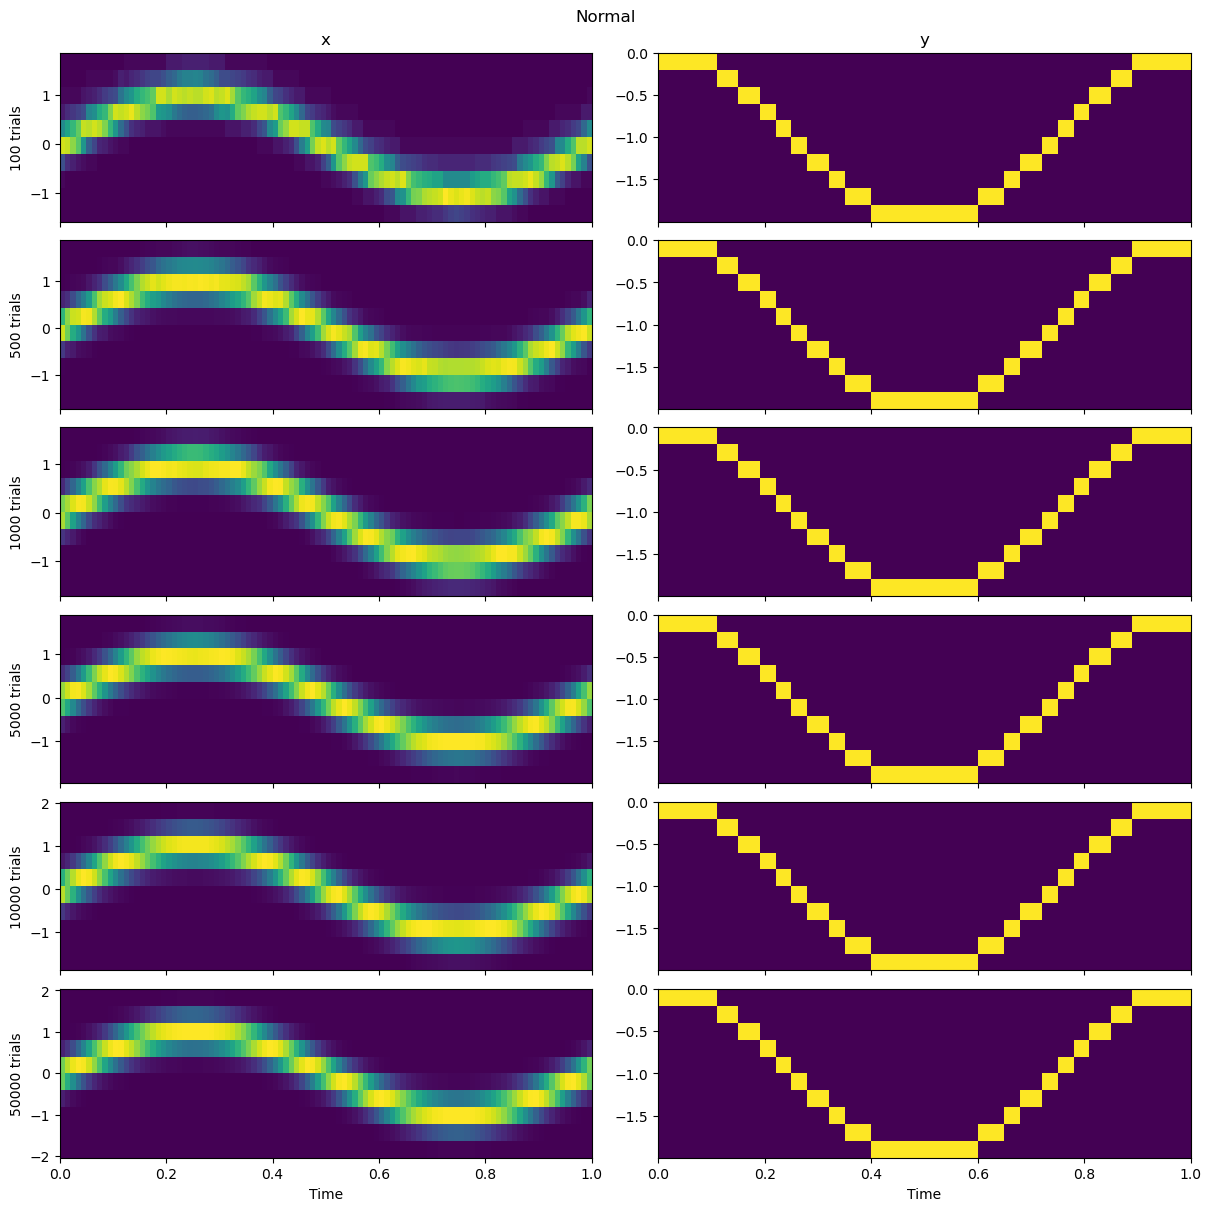

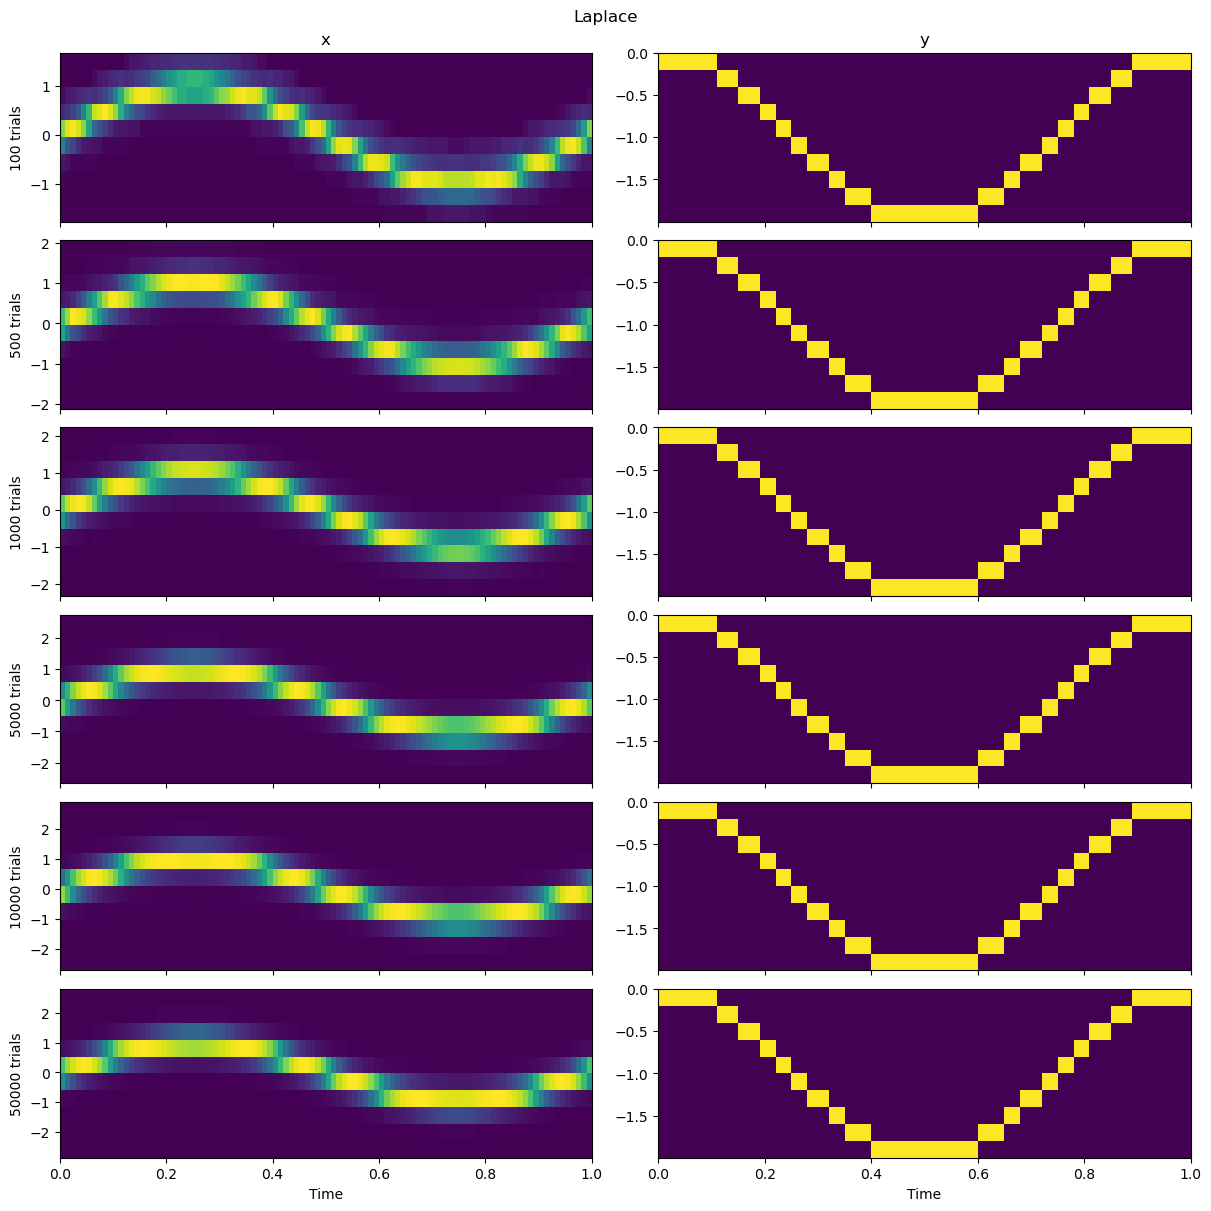

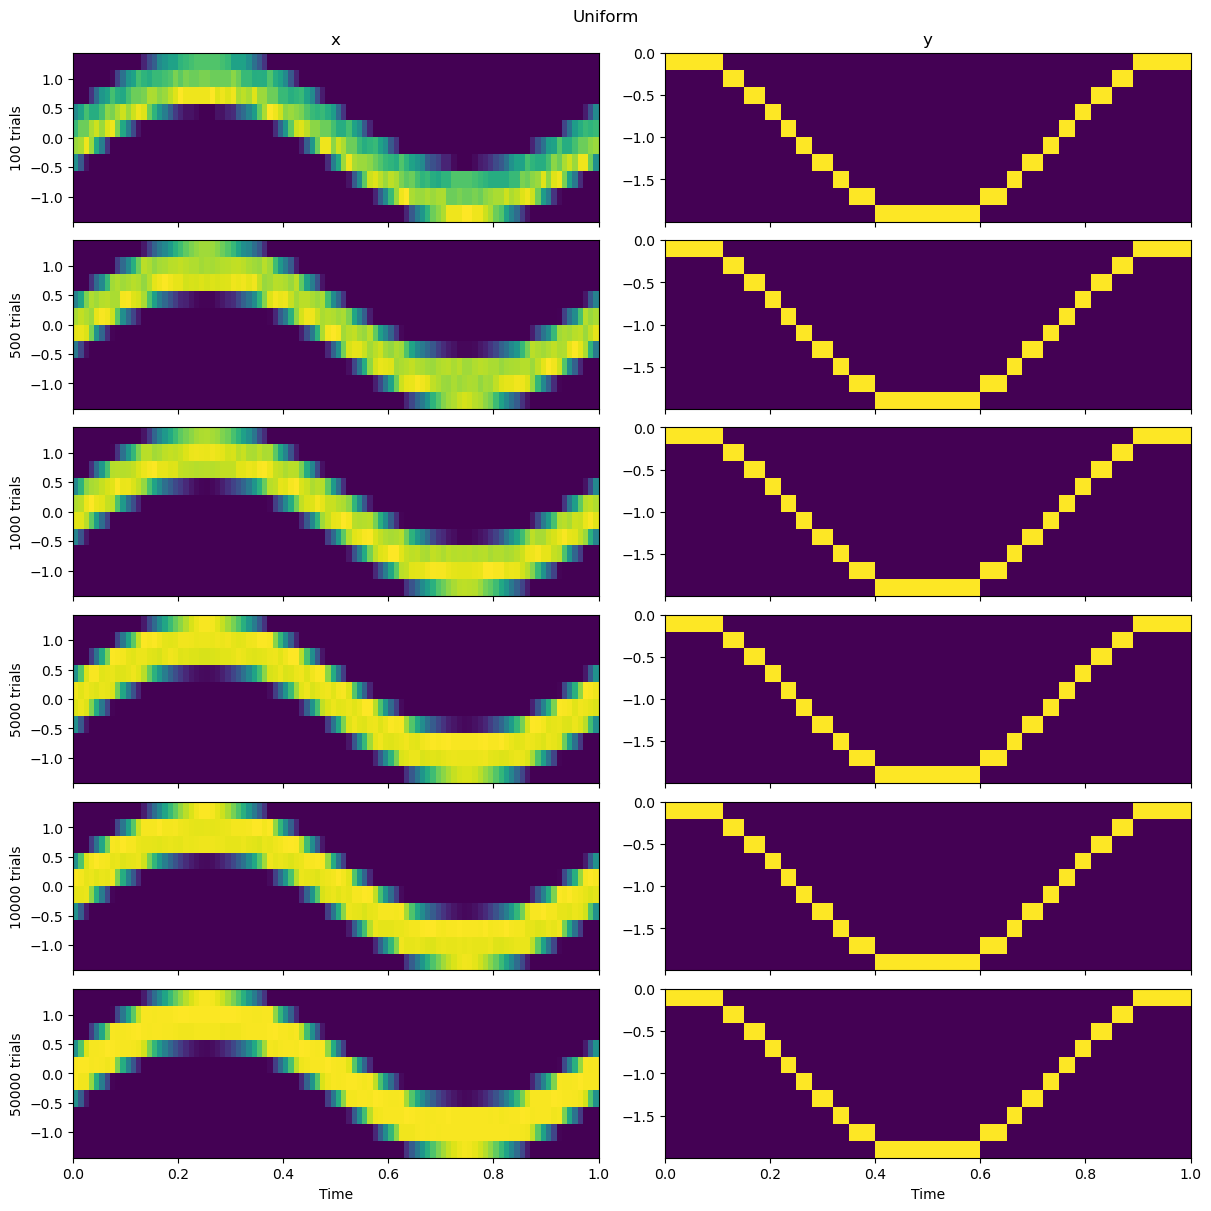

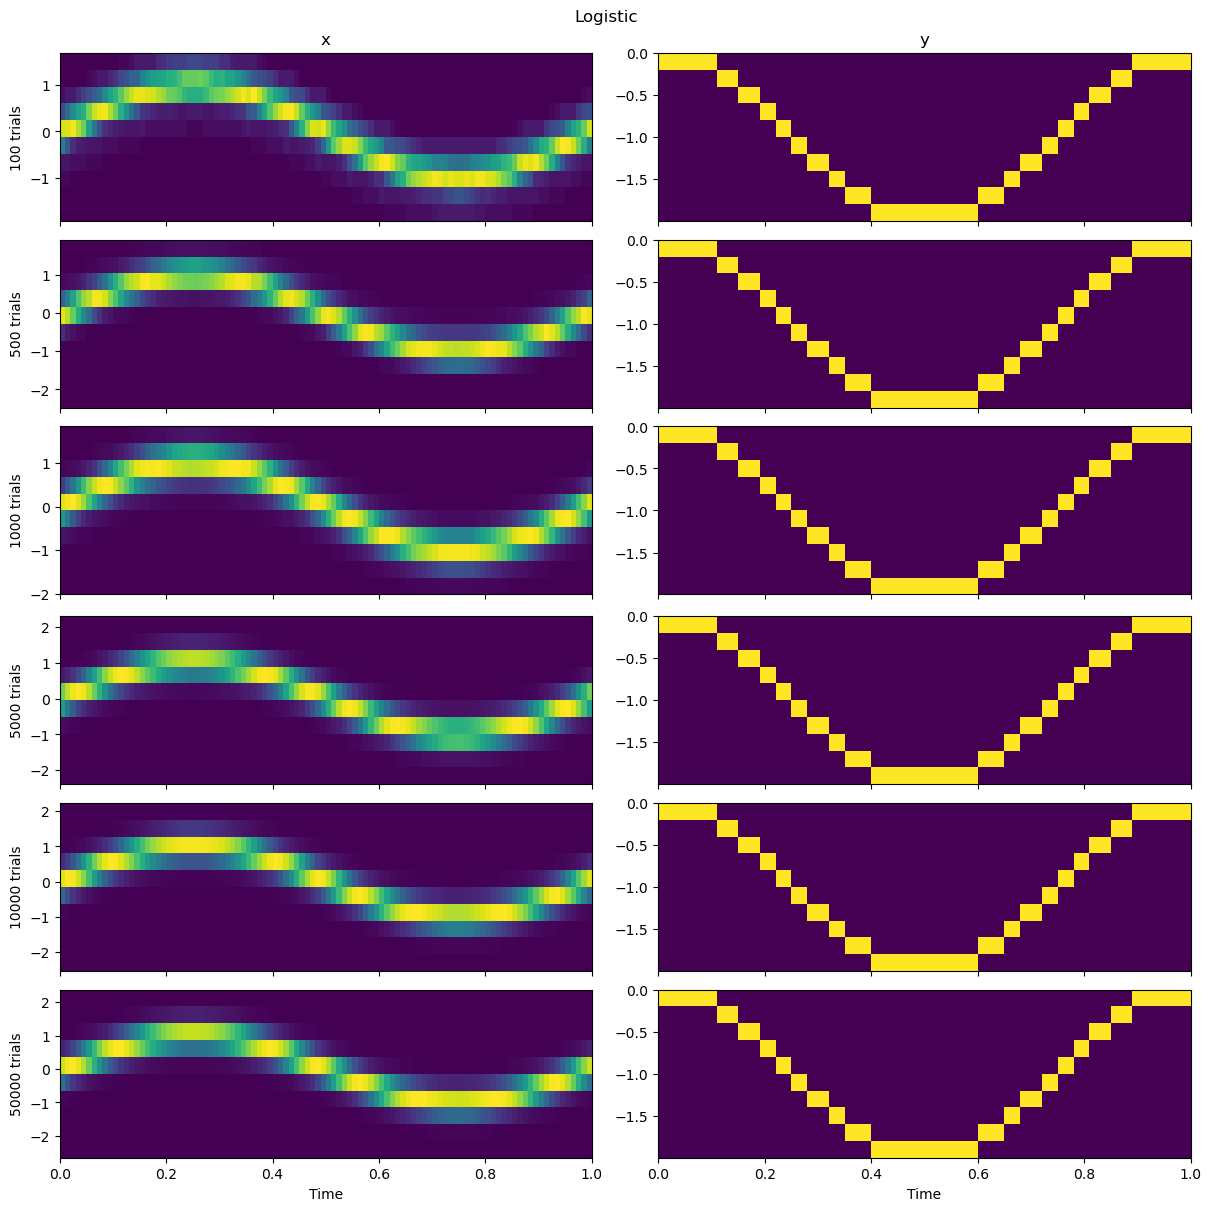

In [5]:
for i, test in enumerate(tests):
    fig = test.plot_distributions()[0]
    fig.suptitle(labels[i])

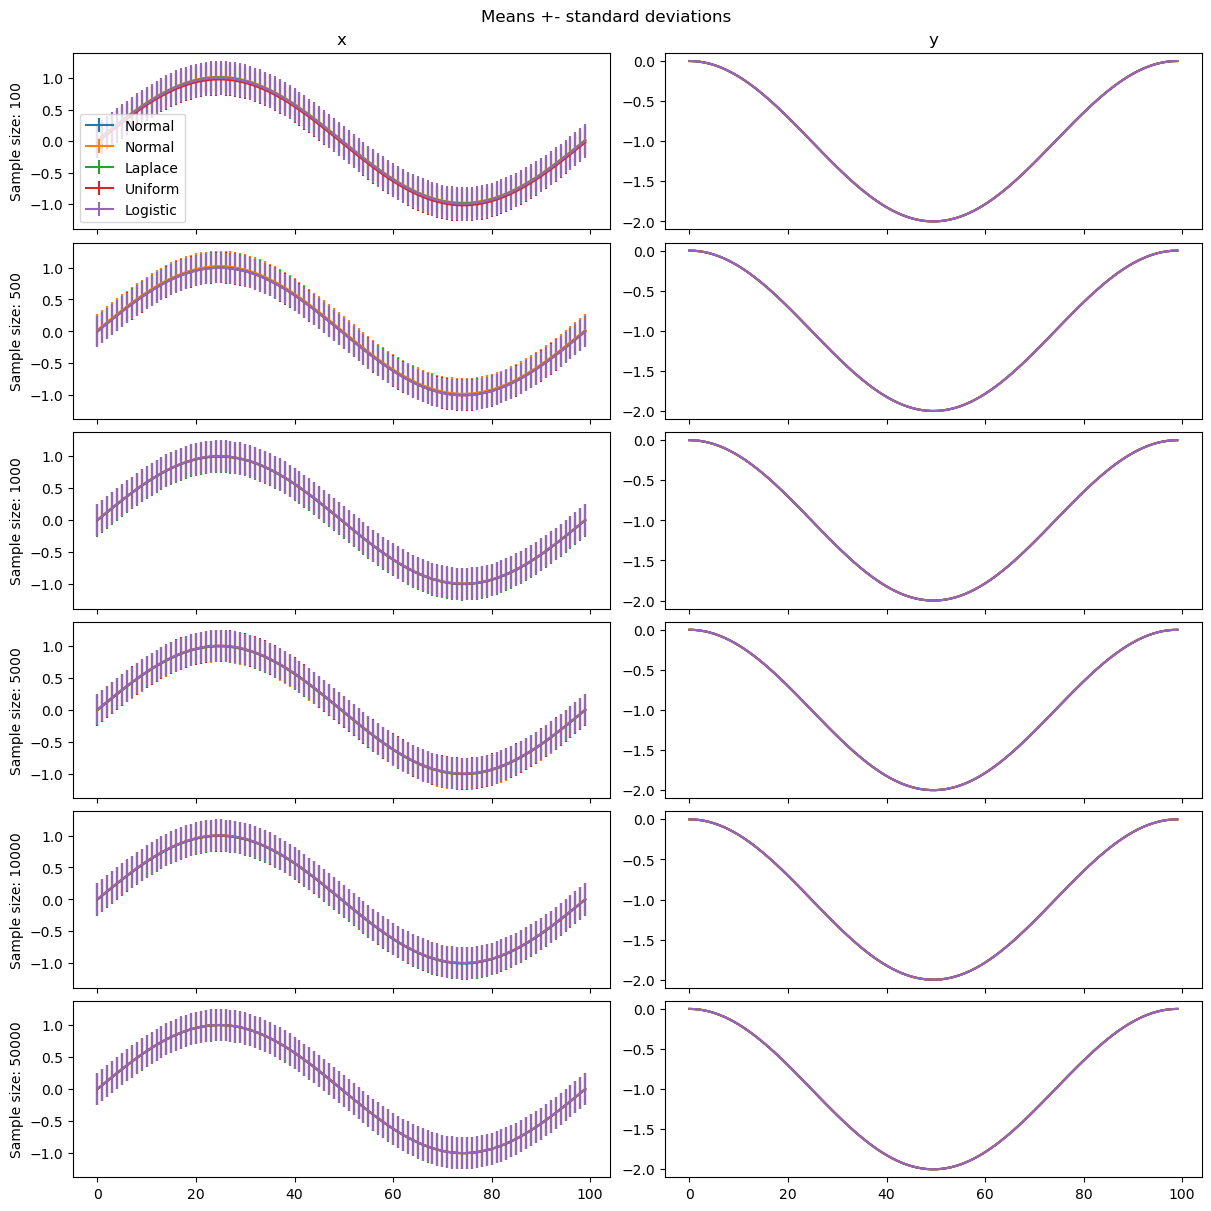

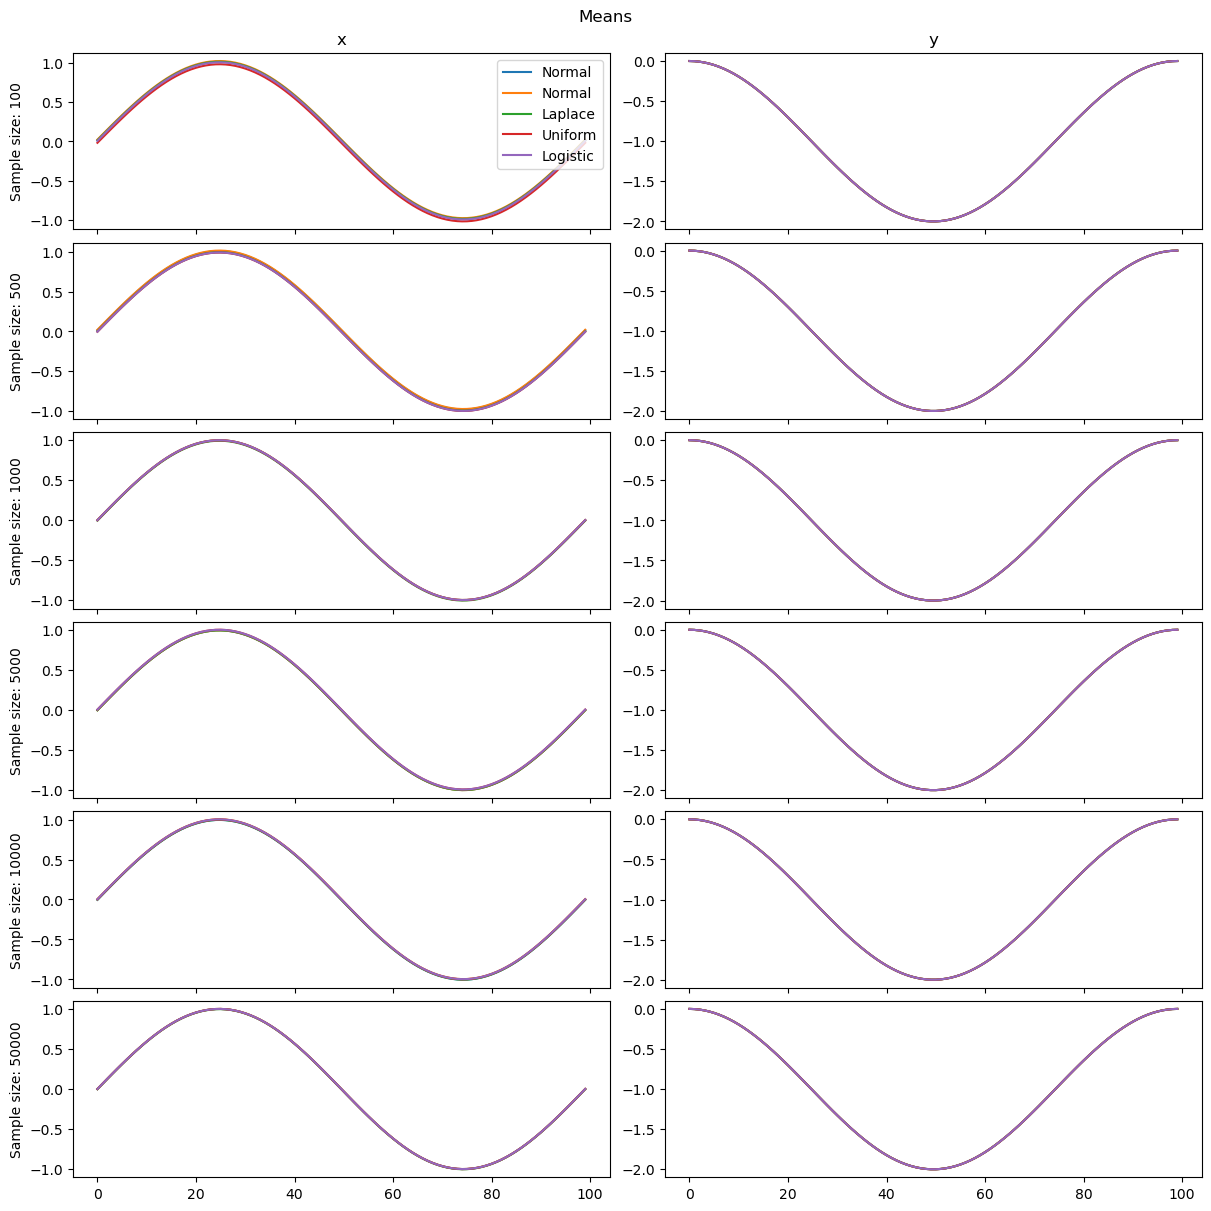

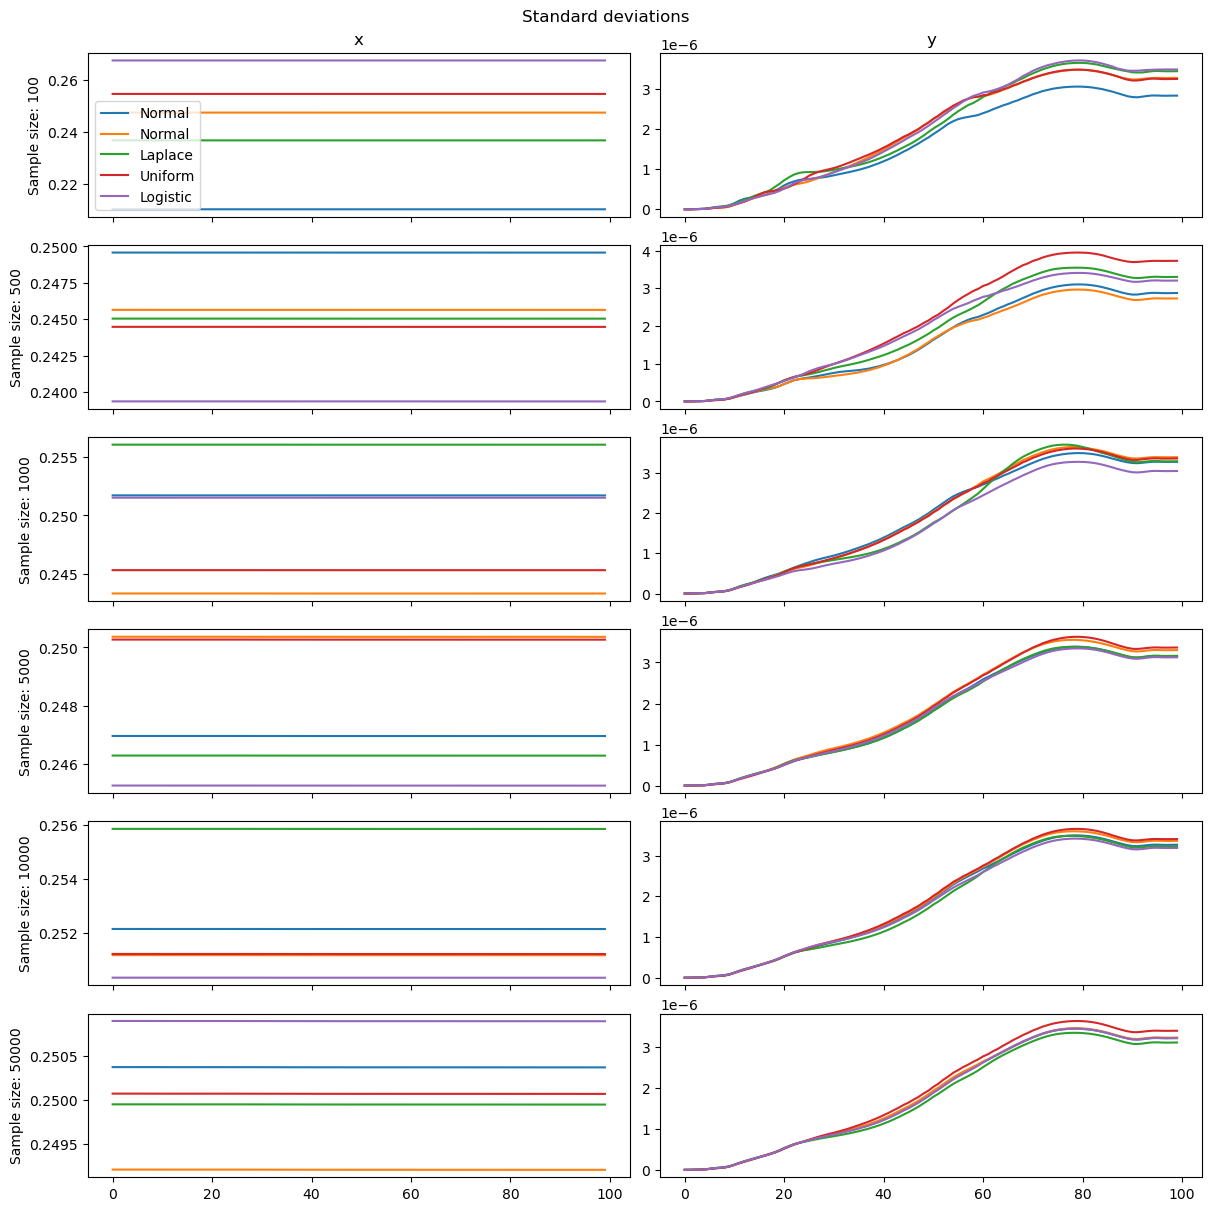

In [6]:
stats_tests = [{t: {n: np.ndarray((num_steps, 2), dtype=float) for n in test1.model.results_names} for t in test_kwargs['trials']} for _ in tests]

for t in test_kwargs['trials']:
    for n in test1.model.results_names:
        for s in range(num_steps):
            for i in range(len(tests)):
                res = tests[i].sims_s[t].extract_var_index(n, s)
                stats_tests[i][t][n][s, :] = np.mean(res), np.std(res)

fig, ax = plt.subplots(len(test_kwargs['trials']), len(test1.model.results_names), figsize=(12.0, 2.0 * len(test_kwargs['trials'])), sharex=True, layout='compressed')
for i, t in enumerate(test_kwargs['trials']):
    for j, n in enumerate(test1.model.results_names):
        for si, s in enumerate(stats_tests):
            ax[i][j].errorbar(np.asarray(list(range(num_steps)), dtype=float), s[t][n][:, 0], yerr=s[t][n][:, 1], label=labels[si])
    ax[i][0].set_ylabel(f'Sample size: {t}')
    
for j, n in enumerate(test1.model.results_names):
    ax[0][j].set_title(n)
fig.suptitle('Means +- standard deviations')
ax[0][0].legend(labels)


fig, ax = plt.subplots(len(test_kwargs['trials']), len(test1.model.results_names), figsize=(12.0, 2.0 * len(test_kwargs['trials'])), sharex=True, layout='compressed')
for i, t in enumerate(test_kwargs['trials']):
    for j, n in enumerate(test1.model.results_names):
        for sn, s in enumerate(stats_tests):
            ax[i][j].plot(np.asarray(list(range(num_steps)), dtype=float), s[t][n][:, 0], label=labels[sn])
    ax[i][0].set_ylabel(f'Sample size: {t}')

for j, n in enumerate(test1.model.results_names):
    ax[0][j].set_title(n)
fig.suptitle('Means')
ax[0][0].legend(labels)


fig, ax = plt.subplots(len(test_kwargs['trials']), len(test1.model.results_names), figsize=(12.0, 2.0 * len(test_kwargs['trials'])), sharex=True, layout='compressed')
for i, t in enumerate(test_kwargs['trials']):
    for j, n in enumerate(test1.model.results_names):
        for sn, s in enumerate(stats_tests):
            ax[i][j].plot(np.asarray(list(range(num_steps)), dtype=float), s[t][n][:, 1], label=labels[sn])
    ax[i][0].set_ylabel(f'Sample size: {t}')

for j, n in enumerate(test1.model.results_names):
    ax[0][j].set_title(n)
fig.suptitle('Standard deviations')
ax[0][0].legend(labels)

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different initial conditions.

In [7]:
test_control.execute_stochastic()
test_control.find_ecfs()
test_control.test_sampling(err_thresh=1E-3)
for test in tests:
    test.find_ecfs()

In [8]:
ecf_diff_all = [{t: [] for t in test_kwargs['trials']} for _ in range(len(tests) - 1)]

trial_oi = test_kwargs['trials'][-1]
idx_oi = 0
err_max_val = 0

for t in test_kwargs['trials']:
    for i in range(num_steps):
        res_1s_n = [{} for _ in range(len(tests) - 1)]
        for n in test1.model.results_names:
            eval_t = sr.get_eval_info_times(test1.ecf_eval_info[t][i][n], False)

            ecf_1 = sr.ecf(test1.sims_s[t].results[n].T[i, :], eval_t)

            for j in range(len(tests) - 1):
                ecf_j = sr.ecf(tests[j+1].sims_s[t].results[n].T[i, :], eval_t)
                res_1s_n[j][n] = sr.ecf_compare(ecf_1[:, 0], ecf_1[:, 1], ecf_j[:, 0], ecf_j[:, 1])

        for j in range(len(tests) - 1):
            ecf_diff_all[j][t].append(res_1s_n[j])

        if t == trial_oi:
            err_max_val_i = max([max(res.values()) for res in res_1s_n])
            if err_max_val_i > err_max_val:
                idx_oi = i
                err_max_val = err_max_val_i

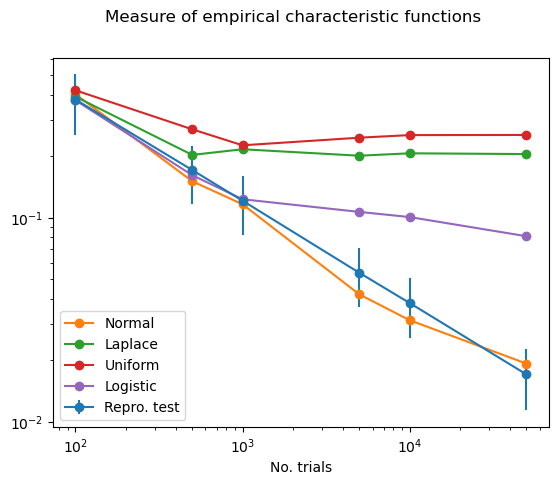

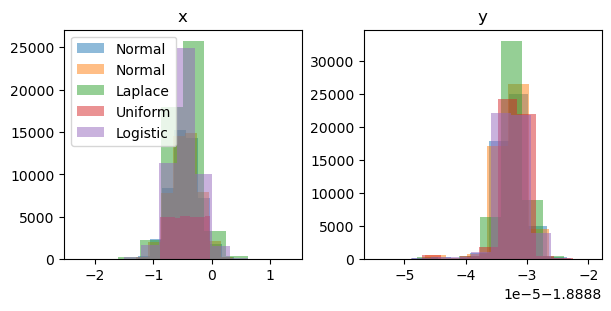

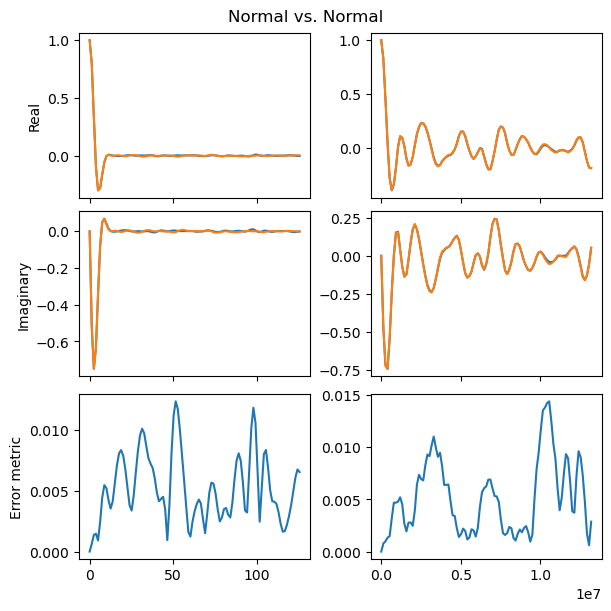

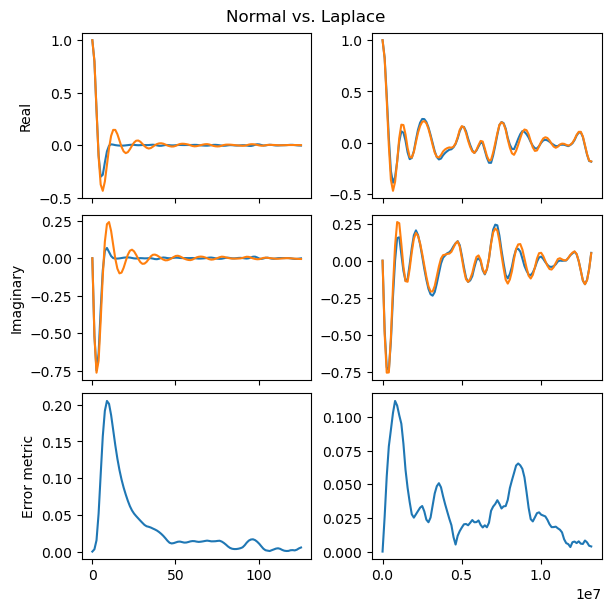

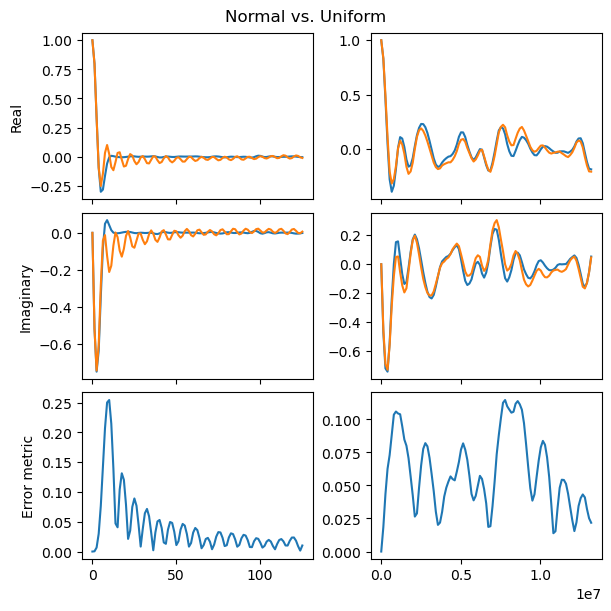

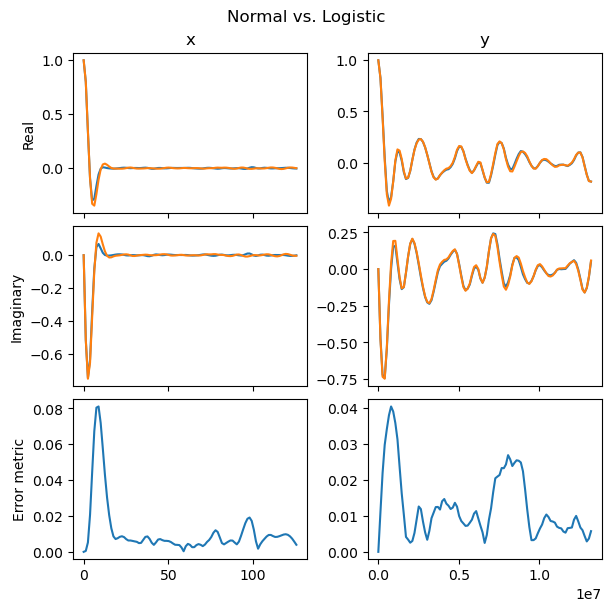

In [10]:
fig, ax = plt.subplots()
ax.errorbar([int(t/2) for t in test_control.trials], 
            [np.average(test_control.ks_stats_sampling[t]) for t in test_control.trials],
            yerr=[np.std(test_control.ks_stats_sampling[t]) * 3 for t in test_control.trials],
            marker='o', label='Repro. test')
for j in range(len(tests[1:])):
    ax.plot(test1.trials, [max([max(el.values()) for el in ecf_diff_all[j][trial]]) for trial in test1.trials], marker='o', label=labels[j+1])
ax.set_xlabel('No. trials')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
fig.suptitle(f'Measure of empirical characteristic functions')

fig, ax = plt.subplots(1, 2, figsize=(6.0, 3.0), layout='compressed')
for j, n in enumerate(test1.model.results_names):
    for i, t in enumerate(tests):
        ax[j].hist(t.sims_s[trial_oi].results[n].T[idx_oi, :], label=labels[i], alpha=0.5)
    ax[j].set_title(n)
ax[0].legend(labels)

for k, t in enumerate(tests[1:]):
    fig, ax = plt.subplots(3, 2, figsize=(6.0, 6.0), sharex='col', layout='compressed')
    for i, n in enumerate(test1.model.results_names):
        eval_t = sr.get_eval_info_times(test1.ecf_eval_info[trial_oi][idx_oi][n], False)
        ecf_1 = sr.ecf(test1.sims_s[trial_oi].results[n].T[idx_oi, :], eval_t)
        ecf_2 = sr.ecf(t.sims_s[trial_oi].results[n].T[idx_oi, :], eval_t)

        for j in range(2):
            ax[j][i].plot(eval_t, ecf_1[:, j])
            ax[j][i].plot(eval_t, ecf_2[:, j])

        d12 = np.sqrt(np.square(ecf_1[:, 0] - ecf_2[:, 0]) + np.square(ecf_1[:, 1] - ecf_2[:, 1]))
        ax[2][i].plot(eval_t, d12)
    fig.suptitle(f'Normal vs. {labels[k+1]}')
    ax[0][0].set_ylabel('Real')
    ax[1][0].set_ylabel('Imaginary')
    ax[2][0].set_ylabel('Error metric')
for i, n in enumerate(test1.model.results_names):
    ax[0][i].set_title(n)